# How to use `if` statements

## Introduction
In this tutorial, you will learn how to use `if` statements in WorkTree.

Load the AiiDA profile.

In [1]:
%load_ext aiida
from aiida import load_profile
load_profile()

Profile<uuid='57ccbf7d9e2b41b39edb2bfdaf725feb' name='default'>

## First workflow: if
Suppose we want to calculate:
```python

def add(x, y):
    return x + y

def multiply(x, y):
    return x*y

# workflow
# step 1
result = add(x, y)
# step 2
if result > 0:
    result = add(result, y)
else:
    result = multiply(result, y)
# step 3
result = add(result, y)
```



### Create node
In order to create a dynamic workflow based on the input value, we need a create a `WorkTree` and then treat this `WorkTree` as a node.

In [11]:
from aiida_worktree import node, WorkTree

# define add node
@node.calcfunction()
def add(x, y):
    return x + y

# define multiply node
@node.calcfunction()
def multiply(x, y):
    return x*y

# Create a WorkTree which is dynamically generated based on the input
# then we output the result of from the context (ctx)
@node.group(outputs = [["ctx.result", "result"]])
def add_multiply_if(x, y):
    wt = WorkTree()
    if x.value > 0:
        add1 = wt.nodes.new(add, name="add1", x=x, y=y)
        # export the result of add1 to the context
        add1.to_ctx = [["result", "result"]]
    else:
        multiply1 = wt.nodes.new(multiply, name="multiply1", x=x, y=y)
        # export the result of multiply1 to the context
        multiply1.to_ctx = [["result", "result"]]
    return wt

### Create the workflow


In [12]:
from aiida_worktree import WorkTree
from aiida.orm import Int, List

x = Int(-1)
y = Int(2)
wt = WorkTree("if_node")
add_multiply_if1 = wt.nodes.new(add_multiply_if, name="add_multiply_if1", x=x, y=y)
add1 = wt.nodes.new(add, name="add1", x=x)
wt.links.new(add_multiply_if1.outputs[0], add1.inputs["y"])

wt.submit(wait=True)

WorkTree node created, PK: 7015


### Check status and results


In [9]:
print("State of WorkTree         : {}".format(wt.state))
print('Result of add_multiply_if1: {}'.format(wt.nodes["add_multiply_if1"].node.outputs.group_outputs.result.value))
print('Result of add1            : {}'.format(wt.nodes["add1"].node.outputs.result.value))

State of WorkTree         : FINISHED
Result of add_multiply_if1: -2
Result of add1            : -3


Generate node graph from the AiiDA process,and we can see that the `multiply` node is executed.

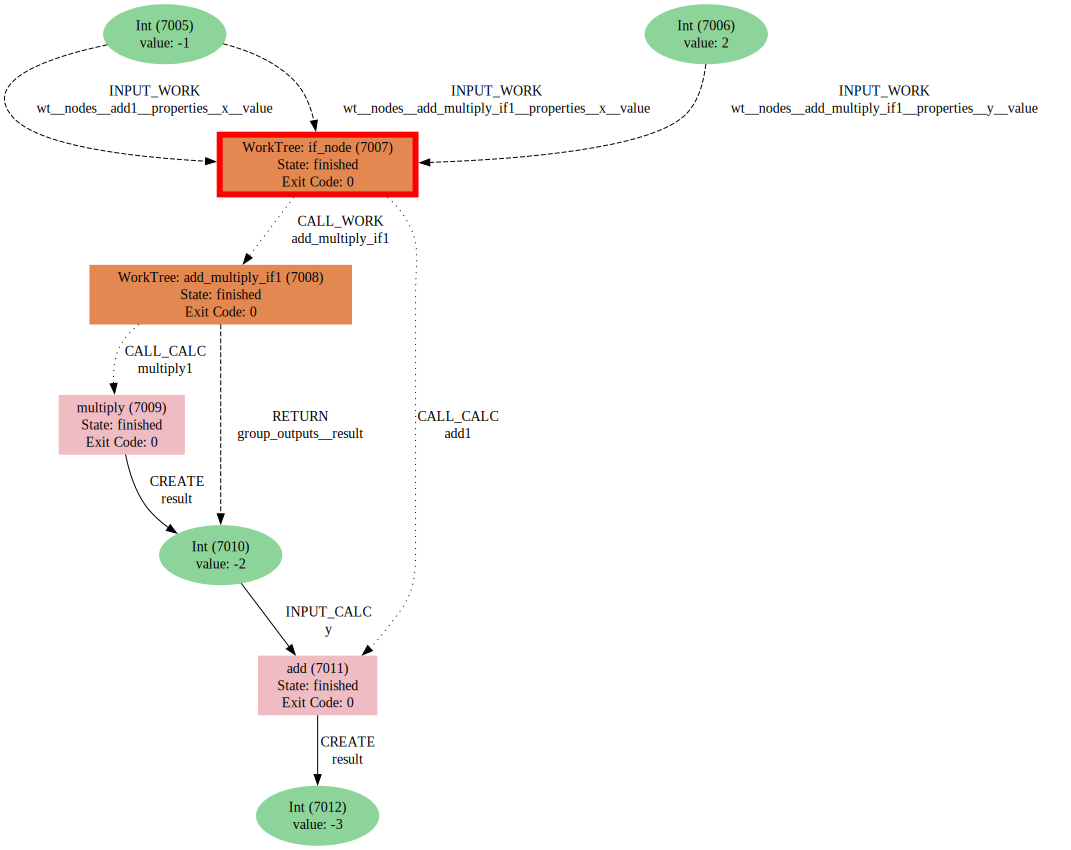

In [10]:
from aiida_worktree.utils import generate_node_graph
generate_node_graph(wt.pk)

Run the workflow using a different input value, and this time the `add` function will be called.

WorkTree node crated, PK: 10996


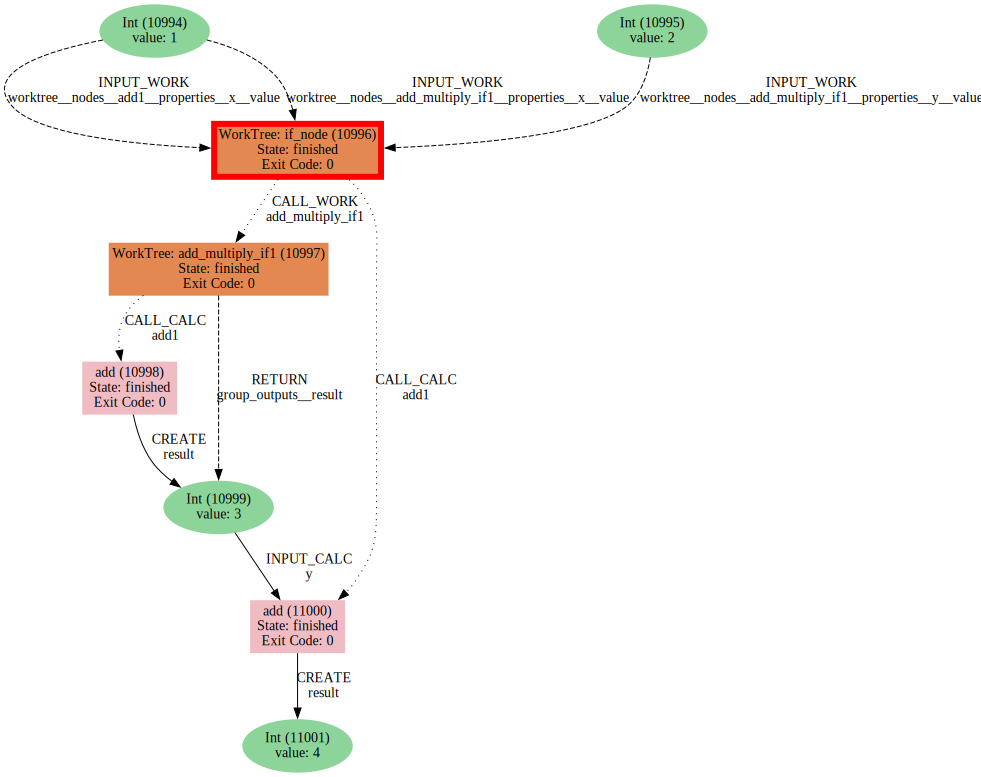

In [6]:
x = Int(1)
y = Int(2)
wt = WorkTree("if_node")
add_multiply_if1 = wt.nodes.new(add_multiply_if, name="add_multiply_if1", x=x, y=y)
add1 = wt.nodes.new(add, name="add1", x=x)
wt.links.new(add_multiply_if1.outputs[0], add1.inputs["y"])

wt.submit(wait=True)
generate_node_graph(wt.pk)
